In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import io
from PIL import Image
import networkx as nx
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 

import warnings

warnings.filterwarnings("ignore", message="The new font size .* is below the current minimum")

In [2]:
def smiles_to_image(smiles, img_size=(300, 300), dpi=500):
    ps = Chem.SmilesParserParams()
    ps.removeHs = True
    mol = Chem.MolFromSmiles(smiles, ps)
    
    # Set image options
    options = Draw.MolDrawOptions()
    draw = Draw.MolDraw2DCairo(img_size[0], img_size[1])  # Using Cairo-based drawing
    draw.SetDrawOptions(options)
    
    # Set DPI
    font_size = max(dpi / 72.0, 6)
    draw.SetFontSize(font_size)  # Adjust font size according to DPI
    draw.DrawMolecule(mol)
    draw.FinishDrawing()
    
    # Convert the image to PIL image
    img = Image.open(io.BytesIO(draw.GetDrawingText()))
    
    return img


def calculate_depths(G, root):
    """Calculate the depth of each node using BFS"""
    depths = {root: 0}
    queue = [(root, 0)]
    while queue:
        node, depth = queue.pop(0)
        for neighbor in G.neighbors(node):
            if neighbor not in depths:  # Skip nodes that have already been visited
                depths[neighbor] = depth + 1
                queue.append((neighbor, depth + 1))
    return depths

def topo_pos(G, root):
    """
    Position the parent node (root) at the top center,
    and position the nodes at each depth with spacing along the x/y axes
    """
    # Calculate the depth of each node
    depths = calculate_depths(G, root)
    
    # Create a list of nodes at each depth
    max_depth = max(depths.values())
    depth_to_nodes = {i: [] for i in range(max_depth + 1)}
    for node, depth in depths.items():
        depth_to_nodes[depth].append(node)
    
    pos_dict = {}
    vertical_spacing = 1 / (max_depth + 1)  # Vertical spacing
    max_width = 1
    # Position nodes at each depth

    for depth, nodes in depth_to_nodes.items():
        num_nodes = len(nodes)
        horizontal_spacing = 1 / (num_nodes + 1)  # Horizontal spacing

        for i, node in enumerate(nodes):
            # Position each node at the current depth, centered
            x_pos = (i + 1) * horizontal_spacing - 0.5  # Center horizontally
            y_pos = 1 - depth * vertical_spacing         # Calculate vertical position
            pos_dict[node] = (x_pos, y_pos)
        max_width = max(max_width, num_nodes)

    return pos_dict, max_depth, max_width

def remove_atom_map(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
    return mol

def draw_molecule_network(prediction, query_smiles_list=[], unit="rank"):
    G = prediction[0]
    root = prediction[1]

    total_sample_size = sum([G[root][node]["count"] for node in G.successors(root)])

    pos, max_depth, max_width = topo_pos(G, root)
    if len(G.nodes) == 1:
        fig, ax = plt.subplots(figsize=(3, 3))  # Set minimum size
    else:
        fig, ax = plt.subplots(figsize=(max(max_width*3, 3), max(max_depth*4.5, 3)))  # Ensure minimum size

    ax.axis('off')
    for node in G.nodes:
        smiles = node  
        img = smiles_to_image(smiles)
        imagebox = OffsetImage(img, zoom=0.5)
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)
        
        # Highlight the queried SMILES with a red circle
        smiles = Chem.MolToSmiles(remove_atom_map(Chem.MolFromSmiles(smiles)))
        query_smiles_list = [Chem.MolToSmiles(Chem.MolFromSmiles(query_smiles)) for query_smiles in query_smiles_list]
        smiles_list = smiles.split(".")
        longest_smiles = max(smiles_list, key=len)

        colors = ["red", "green", "blue", "purple", "cyan", "yellow", "brown"]
        for i, smiles in enumerate(query_smiles_list):
            if longest_smiles == smiles:
                print(longest_smiles, smiles, longest_smiles == smiles)
                circle_radius = 0.005 * max(max_depth, max_width)  # Scale with image size
                circle = plt.Circle(pos[node], circle_radius, color=colors[i], fill=False, linewidth=2)
                ax.add_patch(circle)

    for edge in G.edges(data=True):
        u, v, edge_data = edge


        if u == v:  # Skip self-loop
            x_pos, y_pos = pos[u][0], pos[u][1] - 0.05
            ax.text(x_pos, y_pos, str(edge_data[unit]), fontsize=12, color='black')
            continue
        
        if unit == "count":
            value = (edge_data[unit] / total_sample_size)
        elif unit == "rank":
            value =  1/(edge_data[unit]+1)
        
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=value*1 + 1, # for count
            edge_color='blue', 
            ax=ax
        )
        x_pos = (pos[u][0] + pos[v][0]) / 2  # x position at the middle of the edge
        y_pos = (pos[u][1] + pos[v][1]) / 2  # y position at the middle of the edge
        ax.text(x_pos, y_pos, str(edge_data[unit]), fontsize=12, color='black')

    plt.show()

# Complete graph

Cc1cc(C(F)(F)F)n(-c2cccc(Br)c2)n1 Cc1cc(C(F)(F)F)n(-c2cccc(Br)c2)n1 True
Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 True
Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 True
Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 True
Cc1cc(C(F)(F)F)n(-c2cccc(Br)c2)n1 Cc1cc(C(F)(F)F)n(-c2cccc(Br)c2)n1 True


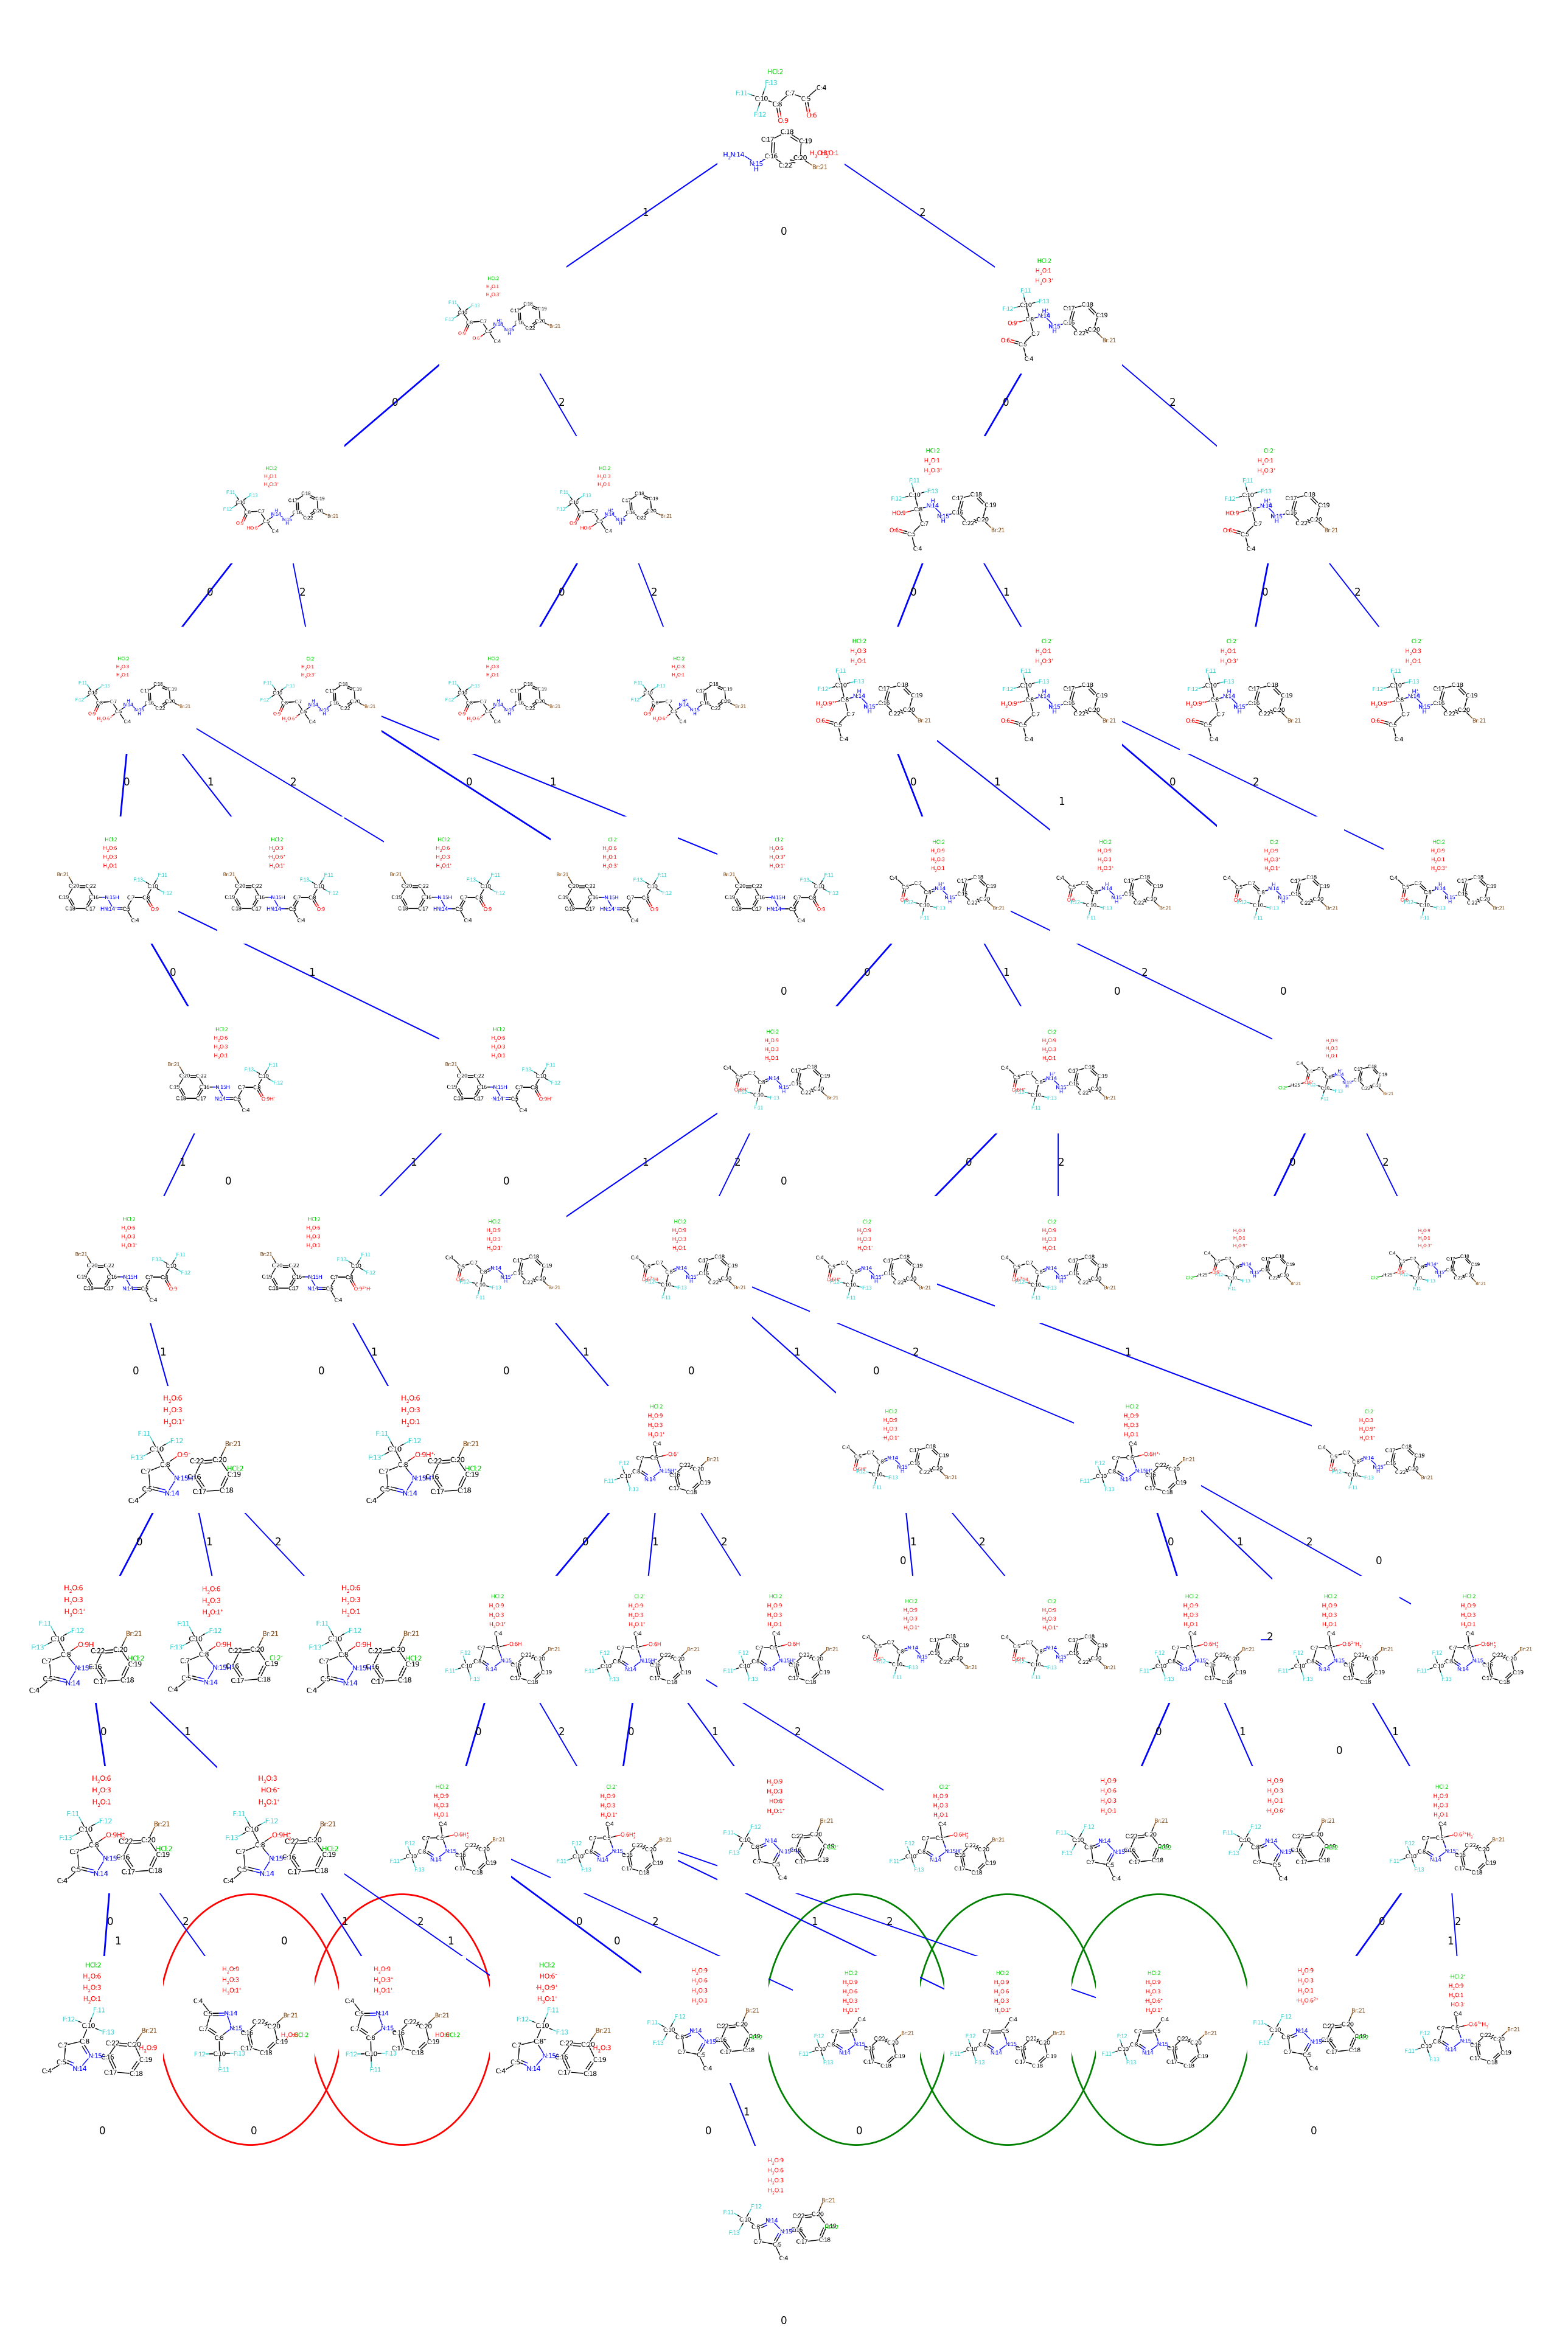

In [ ]:

saving_file = ('samples/unrecognized_pistachio.pkl') # from the paper
# saving_file = ('../results/flower_dataset/best_hyperparam/result_chunk_0_s0.pickle') # view your pathway
# saving_file = ('../results/flower_new_dataset/best_large_hyperparam/result_chunk_0_s0.pickle') # view your pathway


with open(saving_file, 'rb') as file:
    predictions = pickle.load(file)

IDX = 0 # specify which idx you would like to look at
(graph, root, (reactant, products), check) = predictions[IDX]
prune_graph = nx.DiGraph()  # Initialize a new empty graph

for node in graph:
    # Clean node using RDKit's SMILES conversion and atom map removal
    clean_node = Chem.MolToSmiles(remove_atom_map(Chem.MolFromSmiles(node)))
    clean_list = clean_node.split(".")
    
    # If product is in the cleaned node
    for product in products:
        if product in clean_list:
            for path in nx.all_simple_paths(graph, root, node):
                # Iterate through each path and add edges to the new graph
                for i in range(len(path) - 1):
                    # Copy the edge data from the original graph to the new graph
                    edge_data = graph.get_edge_data(path[i], path[i + 1])
                    if not prune_graph.has_edge(path[i], path[i + 1]):
                        prune_graph.add_edge(path[i], path[i + 1], **edge_data)

                edge_data = graph.get_edge_data(path[i+1], path[i+1])
                if edge_data is None: edge_data = {'rank': 100, 'count': 0}
                prune_graph.add_edge(path[i+1], path[i+1], **edge_data)

draw_molecule_network(predictions[IDX], products)

# Prune Graph

Cc1cc(C(F)(F)F)n(-c2cccc(Br)c2)n1 Cc1cc(C(F)(F)F)n(-c2cccc(Br)c2)n1 True
Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 True
Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 True
Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 Cc1cc(C(F)(F)F)nn1-c1cccc(Br)c1 True
Cc1cc(C(F)(F)F)n(-c2cccc(Br)c2)n1 Cc1cc(C(F)(F)F)n(-c2cccc(Br)c2)n1 True


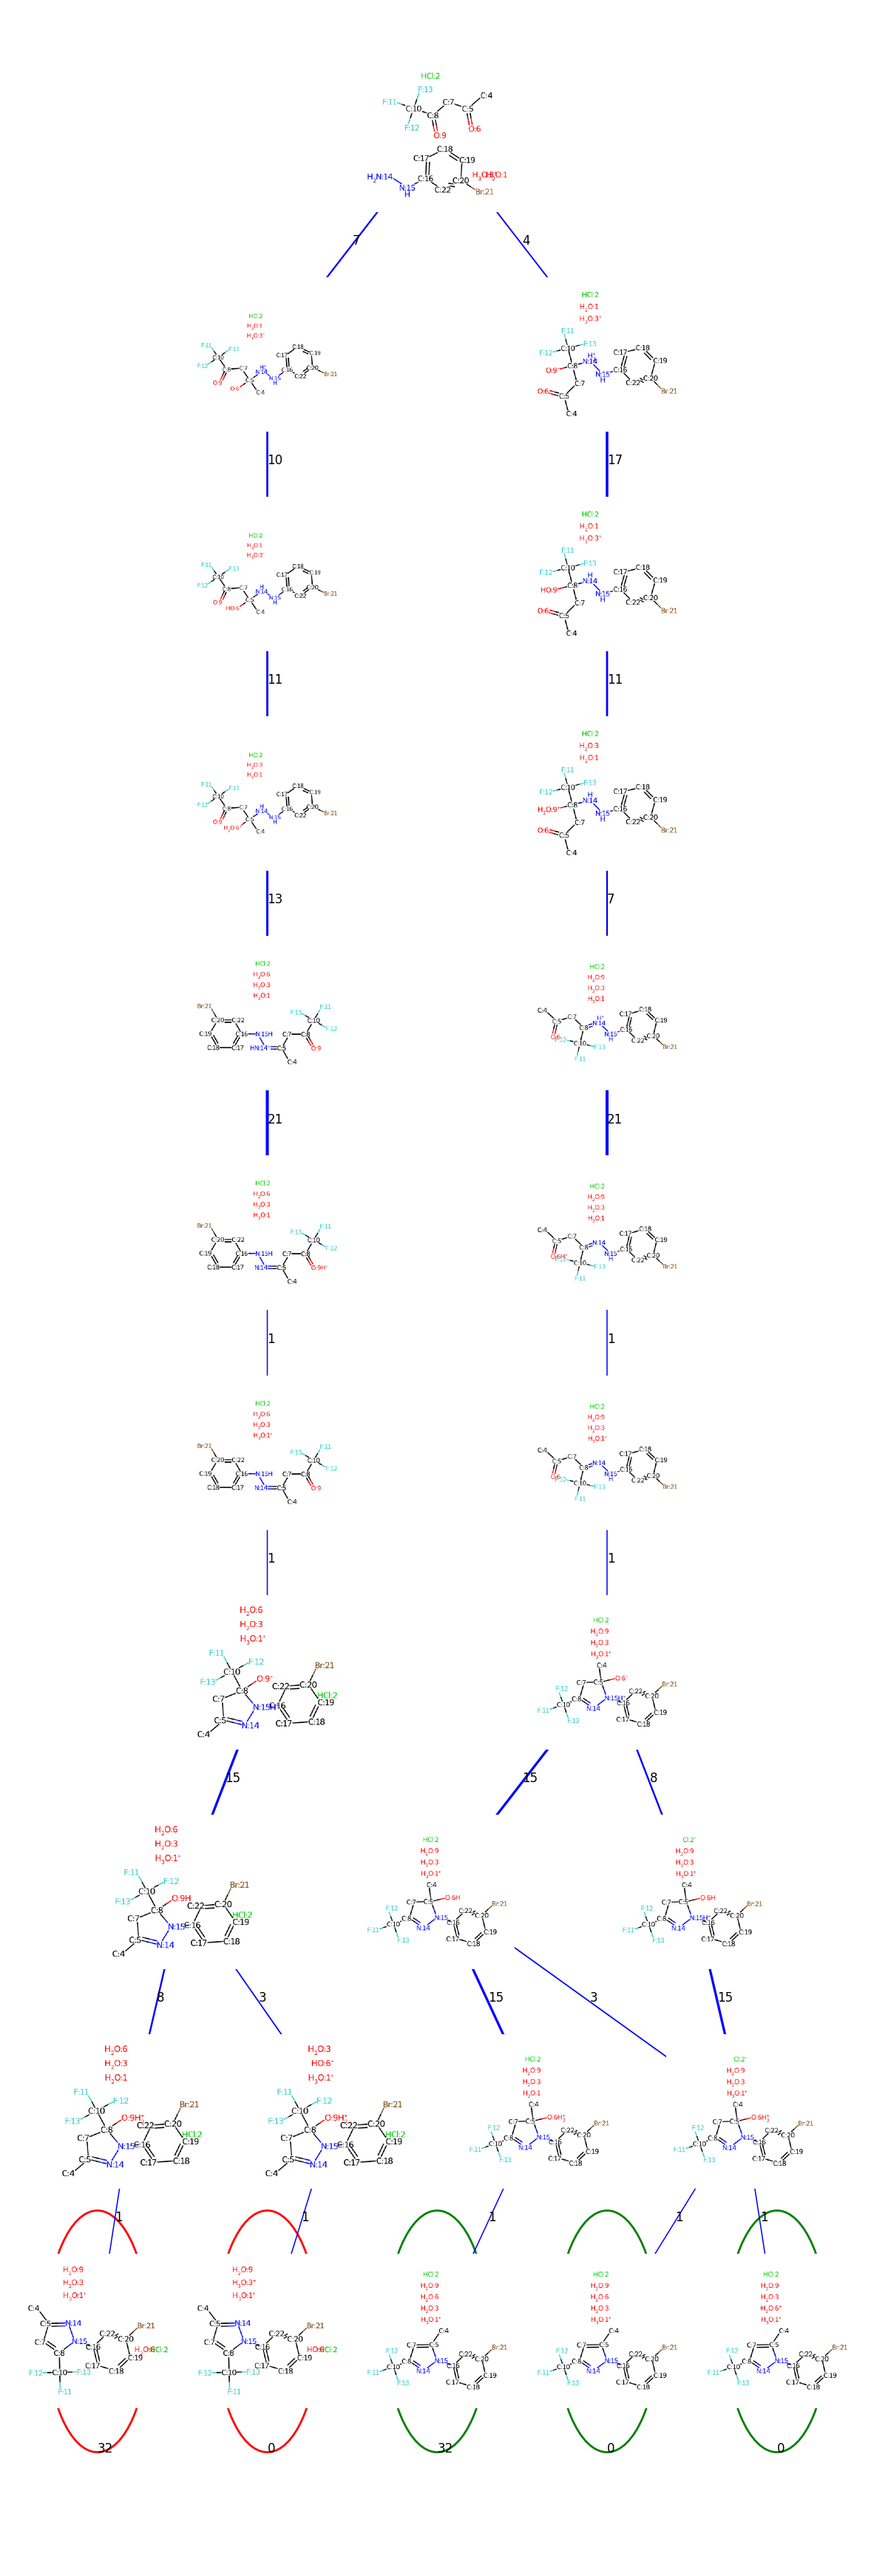

In [4]:
assert bool(prune_graph) == True
draw_molecule_network((prune_graph, root), products, unit="count")